<h1 id="adda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> TPS - JULY 2022 - Unsupervised clustering challenge </h1>

### Problem definition :

* In this challenge, we are given a dataset where each row belongs to a particular cluster. our job is to predict the cluster each row belongs to .

### Data :
* data.csv - the file includes **continuous** and **categorical** data; your task is to predict which rows should be clustered together in a control state

* sample_submission.csv - a sample submission file in the correct format, where Predicted is the predicted control state


<h1 id="addfdsda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Libraries </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA #Only for visualizing
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,QuantileTransformer
import plotly.express as px

sns.set()

<h1 id="adhdeyda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Reducing memory usage and loading the data </h1>

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
data = import_data('../input/tabular-playground-series-jul-2022/data.csv')
sub = import_data('../input/tabular-playground-series-jul-2022/sample_submission.csv')

data

Memory usage of dataframe is 22.43 MB
Memory usage after optimization is: 5.14 MB
Decreased by 77.1%
Memory usage of dataframe is 1.50 MB
Memory usage after optimization is: 0.47 MB
Decreased by 68.7%


id      f_00      f_01      f_02      f_03      f_04      f_05  \
0          0 -0.389404 -0.912598  0.648926  0.588867 -0.831055  0.733398   
1          1 -0.689453 -0.453857  0.654297  0.995117 -1.653320  0.863770   
2          2  0.809082  0.324463 -1.170898 -0.624512  0.105469  0.784180   
3          3 -0.500977  0.229004  0.264160  0.231567  0.415039 -1.221680   
4          4 -0.671387 -1.039062 -0.270264 -1.830078 -0.290039 -1.852539   
...      ...       ...       ...       ...       ...       ...       ...   
97995  97995  0.237549  1.657227 -0.689453  0.313721 -0.299072  0.329102   
97996  97996  0.322754  0.710449  0.562500 -1.321289 -0.357666  0.182007   
97997  97997 -0.249390 -0.459473  1.885742 -1.339844  0.195068 -0.559570   
97998  97998  0.311523  2.185547  0.761230  0.436768  0.465088  0.062317   
97999  97999  0.755371  0.567383  1.457031 -0.579102 -0.048462 -1.206055   

           f_06  f_07  f_08  ...      f_19      f_20      f_21      f_22  \
0      2.257812     2    13  ... -0.478516 -0.756836 -0.763672 -1.090820   
1     -0.090637     2     3  ... -0.428711 -0.089905 -1.784180 -0.839355   
2      1.988281     5    11  ... -0.413574 -1.602539  1.191406  3.267578   
3      0.138794     6     2  ...  0.619141  1.288086  0.532715  1.037109   
4      0.781738     8     7  ... -1.628906 -0.435059  0.322510  0.284424   
...         ...   ...   ...  ...       ...       ...       ...       ...   
97995  1.607422     5     7  ... -0.290039 -0.258057 -0.973633  1.369141   
97996  0.178589     3     9  ...  0.117676  1.388672  0.342285  1.680664   
97997 -0.379883     8     9  ... -0.850098 -1.788086 -1.268555 -1.508789   
97998 -0.333984     1     8  ... -0.010841  1.119141  1.565430  0.358398   
97999  0.784180     0    11  ...  1.180664 -0.925781 -1.369141 -2.464844   

           f_23      f_24      f_25      f_26      f_27      f_28  
0      1.142578 -0.884277  1.137695  1.308594  1.462891  0.813477  
1      0.459717  1.759766 -0.275391 -0.852051  0.562500 -2.679688  
2     -0.088318 -2.167969 -0.975098  1.335938 -1.110352 -3.630859  
3     -2.041016  1.440430 -1.900391 -0.630859 -0.050629  0.238281  
4     -2.437500  1.473633 -1.044922  1.602539 -0.405273 -1.987305  
...         ...       ...       ...       ...       ...       ...  
97995  0.391113  2.152344 -0.208984 -1.475586  0.298340  0.445068  
97996 -0.860352  0.579102  1.163086  0.135010  0.994629  0.727539  
97997  1.945312  1.503906  0.194946  2.142578  1.646484  0.641602  
97998  0.547852  1.224609 -0.538086 -1.611328 -0.616211 -0.066223  
97999  1.453125 -1.685547  0.129639 -0.970703  1.405273 -0.710938  

[98000 rows x 30 columns]

<h1 id="awdjjjja" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Info </h1>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int32  
 1   f_00    98000 non-null  float16
 2   f_01    98000 non-null  float16
 3   f_02    98000 non-null  float16
 4   f_03    98000 non-null  float16
 5   f_04    98000 non-null  float16
 6   f_05    98000 non-null  float16
 7   f_06    98000 non-null  float16
 8   f_07    98000 non-null  int8   
 9   f_08    98000 non-null  int8   
 10  f_09    98000 non-null  int8   
 11  f_10    98000 non-null  int8   
 12  f_11    98000 non-null  int8   
 13  f_12    98000 non-null  int8   
 14  f_13    98000 non-null  int8   
 15  f_14    98000 non-null  float16
 16  f_15    98000 non-null  float16
 17  f_16    98000 non-null  float16
 18  f_17    98000 non-null  float16
 19  f_18    98000 non-null  float16
 20  f_19    98000 non-null  float16
 21  f_20    98000 non-null  float16
 22

<h3 class="alert alert-info"> Data has no missing values </h3>

# Drop id

In [5]:
data=data.drop('id',axis=1)

<h1 id="addawwdda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Correlation between continuous features </h1>

In [6]:
Continuous_Features = data.select_dtypes(include='float16')

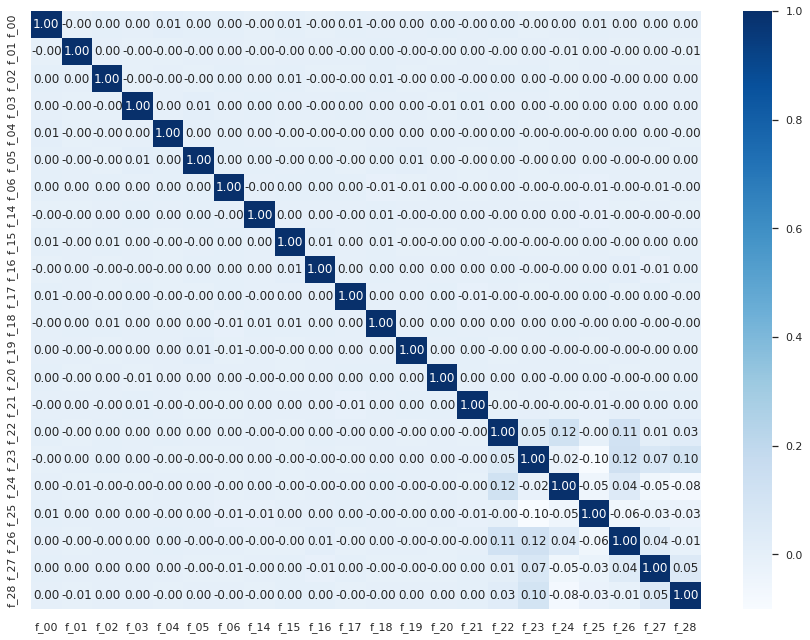

In [7]:
plt.figure(figsize = ( 15 , 11 ))
sns.heatmap(Continuous_Features.corr(),annot=True,fmt=".2f", cmap='Blues');

<h3 class="alert alert-info"> Features are not correlated with each other </h3>

<h1 id="addawrjda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Continuous features distribution </h1>

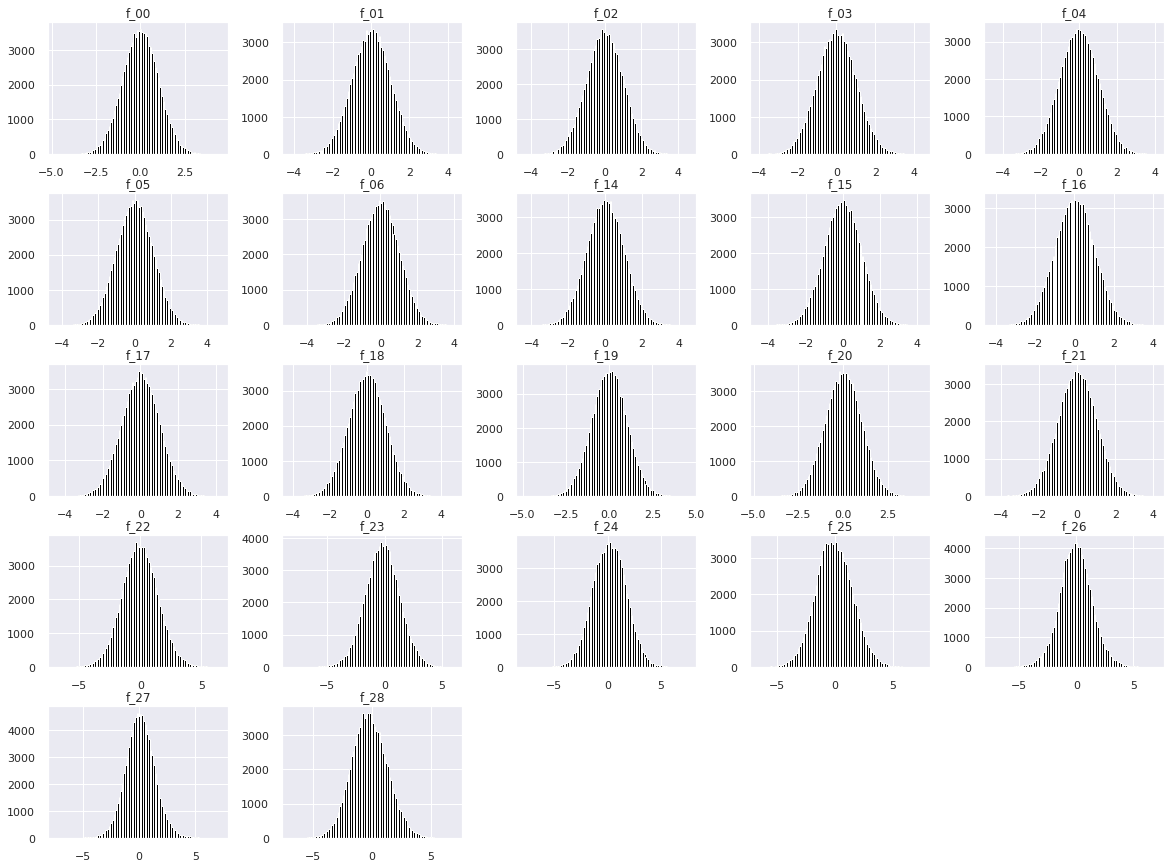

In [8]:
Continuous_Features.hist(figsize=(20,15),bins=100,color='#000');

<h3 class="alert alert-info"> Features have approximately normal distribution </h3>

<h1 id="addaggdd" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Outliers </h1>

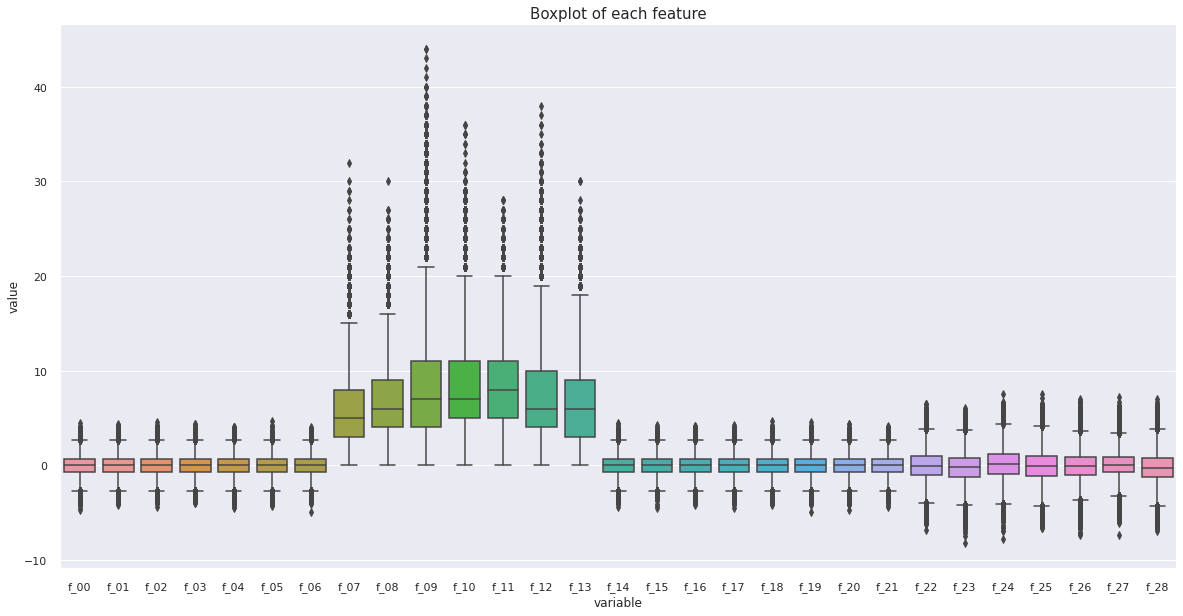

In [9]:
tmp_df = pd.DataFrame(data = data, columns = data.columns.to_list())
plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(tmp_df)).set_title('Boxplot of each feature',size=15)

plt.show()

<h3 class="alert alert-info"> There are outliers especially in categorical features </h3>

<h1 id="agrywdda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Preprocessor function </h1>


In [10]:
#Remove outliers
QT = QuantileTransformer(output_distribution='normal')

#Scaler
Robust = RobustScaler() # Better score

def my_transformer(X):
    X = Robust.fit_transform(X)
    X = QT.fit_transform(X)
    return X

<h1 id="adggddweda" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Finding optimal number of clusters using K-means </h1>

The number of clusters that we choose for a given dataset cannot be random. Each cluster is formed by calculating and comparing the distances of data points within a cluster to its centroid. An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)

## Kmeans Clustering and storing WCSS for each K

In [11]:
X_scaled = my_transformer(data)

#Clustering function
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    return kmeans


# Clustering and storing WCSS for each K
WCSS = []

for k in range(1, 15):
    kmeans = cluster(k)
    WCSS.append(kmeans.inertia_)

## Plot WCSS against number of clusters

In [12]:
px.line(x=range(1,15), y=WCSS ,
       labels={'y':'WCSS', 'x':'Number of clusters'},
       title="Investigate K-means clustering")

## An easier way: Use KElbowVisualizer to get the exact value of elbow point
For more information read the documentation [here](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

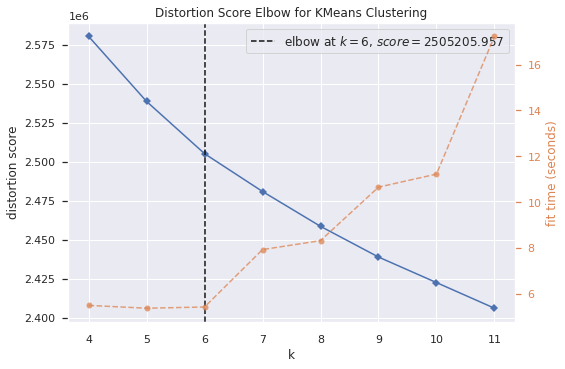

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<h3 class="alert alert-info"> The Elbow method suggests 7 as optimal number of clusters</h3>

<h1 id="addffswtjuja" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Clustering </h1>

## K-means

In [14]:
# Preprocess data
X_scaled = my_transformer(data)

# Do kmeans clustering
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_scaled)
preds=kmeans.predict(X_scaled)

In [15]:
sub['Predicted']=preds
sub.to_csv('submission_Kmeans.csv',index=False)

<h3 class="alert alert-info"> Submission score : 0.24916 </h3>

## Bayesian Gaussian Mixture

In [16]:
X_scaled = my_transformer(data)
 
preds = BayesianGaussianMixture(n_components=7,
                                covariance_type='full',
                                max_iter=1000,
                                random_state=1).fit_predict(X_scaled)

In [17]:
# Create submission file
sub['Predicted']=preds
sub.to_csv('submission.csv',index=False)

<h3 class="alert alert-info"> Submission score : 0.59491 </h3>

<h1 id="addffswtjuja" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> PCA & visualize clusters

In [18]:
pca = PCA(n_components=3)

PCA_DF = pd.DataFrame(pca.fit_transform(X_scaled), columns=(["col1","col2","col3"]))
PCA_DF["Cluster"]=preds


In [19]:
fig = px.scatter_3d(PCA_DF, x='col1', y='col2', z='col3',
              color='Cluster')
fig.show()

### Still working on it . . .

### Take a look at my notebooks [here](https://www.kaggle.com/mehrdadsadeghi/code)

## Credits 

* https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook
* https://www.kaggle.com/code/sfktrkl/tps-july-2022/notebook?scriptVersionId=99952091